<a href="https://www.inove.com.ar"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/PA%20Banner.png" width="1000" align="center"></a>


# Ejercicio de clasificación con Random Forest

Ejemplo de clasificación utilizando random forest para la clasificación de drogadas que debería tomar un pasiente según su historial clínico<br>

v2.0

### Objetivos: 
*   Preprocesar los datos (descarga, lectura, limplieza y filtrado).
*   Conocer como funciona el algoritmo clasificación con Random Forest.
*   Evaluar el resultado el algoritmo clasificación con Random Forest.

**Random Forest:** Un bosque aleatorio es un metaestimador que ajusta una serie de clasificadores de árboles de decisión en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste. 

Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [1]:
#Librerias a implementar
import os
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Recolectar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline1.png" width="1000" align="middle">

### Código de descarga del dataset

In [2]:
if os.access('drug200.csv', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/drug200.csv > drug200.csv
    else:
        !wget drug200.csv https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/drug200.csv

--2023-03-09 20:16:09--  http://drug200.csv/
Resolving drug200.csv (drug200.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘drug200.csv’
--2023-03-09 20:16:09--  https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/drug200.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6027 (5.9K) [text/plain]
Saving to: ‘drug200.csv’

drug200.csv         100%[===================>]   5.89K  --.-KB/s    in 0s      

2023-03-09 20:16:09 (57.1 MB/s) - ‘drug200.csv’ saved [6027/6027]

FINISHED --2023-03-09 20:16:09--
Total wall clock time: 0.3s
Downloaded: 1 files, 5.9K in 0s (57.1 MB/s)


### `drug200.csv`:
El dataset **`drug200.csv`** contiene diferentes tipos de drogas que se le dan a pacientes relativo a su historial clínico. El objetivo es dado un nuevo paciente clasificarlo y determinar que droga es la más apropiada para el.<br> [Dataset source](https://www.kaggle.com/jeevanrh/drug200csv)

- **Age** --> edad, ejemplo 25
- **Sex** --> género, ejemplo F(femenino), M(masculino)
- **BP (Blood Pressure)** --> presión arterial, ejemplo HIGH(alta)
- **Cholesterol** --> colesterol, ejemplo normal (NORMAL)
- **Na / k** --> concentración de sodio/potasio en sangre, ejemplo 7.8
- **Drug** --> droga suministrada, ejemplo drugC

# Procesar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline2.png" width="1000" align="middle">

In [3]:
# Una vez descargado el archivo en Colab.
# Leerlo con Pandas y el método read_csv
# Una vez extraida toda la información se almacena en df
# A partir de df y el método describe(), mostrará la descripción estadistica básica del archivo que se guardará en des
# Crear una fila nueva llamada Nan en el DataFrame  des,
# que indica la cantidad de datos tipo Nan que tiene cada columna.
# Para crear una nueva fila, se utilizará el operador loc, donde se indica el nombre
# de la nueva fila y con que valores se completará.
# La información será de los datos faltantes df.isna().sum()
# Crear una fila nueva llamada %Nan en el DataFrame des,
# Esta fila se completará con los porcentajes de Nan encontrados en cada columna.

df = pd.read_csv("drug200.csv")
des = df.describe()
des.loc['Nan'] = df.isna().sum()
des.loc['%Nan'] = (df.isna().mean())*100
des

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000
Nan,0.000000,0.000000
%Nan,0.000000,0.000000


In [4]:
# Muestra las 5 primeras filas del DataFrame df
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [5]:
# Cantidad de filas y columnas con shape
# En la ubicación 0 corresponde a las filas
print('Cantidad de datos en observacion:', df.shape[0])

Cantidad de datos en observacion: 200


# Explorar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline3.png" width="1000" align="middle">

In [6]:
# Se accede a la columna "Drug" para contar la frecuencia de los valores únicos
# (Cuenta cuántas veces se dio cada droga).
df['Drug'].value_counts()

drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

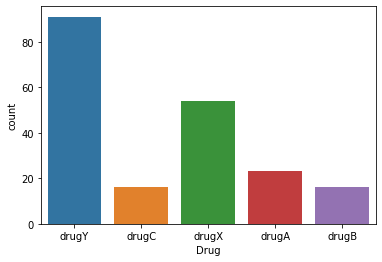

In [7]:
# Se representa graficamente la frecuencia de las drogas dadas.
# Esto permite explorar que tan balanceado está el dataset.
# Donde se puede ver en cuantos casos se suministró cada droga.
# sns, alias de Seaborn
# countplot(), gráfico de barras
# Necesita toda la data
# Se especifica la columna a representar, en este caso "Drug"
sns.countplot(data=df, x="Drug")

# Muestra el gráfico
plt.show()

Se puede observar que en la mayoría de los casos se suministra la drogaY o la drogaX, es muy probable que el modelo siga esta tendencia

#### Transformar variables categóricas texto, a clases numeradas

In [8]:
#Librerias a implementar
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Se hace una copia del df inicial en df_cod
df_codificado = df.copy()

In [9]:
# Muestra las 5 primeras filas del DataFrame df_codificado
df_codificado.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


 ### LabelEncoder

In [10]:
# Se crea el objeto "le" que significa label encoder a partir de la clase LabelEncoder()
# Del objeto "le" se puede acceder al método fit_transform con la notación del punto, para que 
# asigne un número a cada categoría existente en la columna.
le_sex = LabelEncoder()
label_encoding = le_sex.fit_transform(df_codificado['Sex'])
label_encoding

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0])

### OneHotEncoder

In [11]:
# Se crea el objeto "onehot_encoder" a partir de la clase OneHotEncoder()
# Se indica sparse=False para que la matriz no esté dispersa.
# A partir del objeto creado "onehot_encoder", se accede al método fit_transform()
# Importante; para aplicar el One Hot Encoder se necesita que los datos esten en un array 
# Con el label enconde aplicado, haciendo el ajuste con reshape(-1, 1)
ohe_sex = OneHotEncoder(sparse=False)
one_hot_encoding = ohe_sex.fit_transform(label_encoding.reshape(-1, 1))
one_hot_encoding

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [12]:
# Crear un DataFrame con los resultados del "one_hot_encoding"
# Necesita indicar los datos (en su formato array), las columnas a través de "le"(label encoder)
# Con dtype=int se indica el tipo de dato como entero.
df_ohe = pd.DataFrame(one_hot_encoding, columns=le_sex.classes_, dtype=int)
df_ohe 

,F,M
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
195,1,0
196,0,1
197,0,1
198,0,1


In [13]:
# Agregar sufijo a cada columna del DataFrame "df_ohe"
# df_ohe, el DataFrame  se sobreescribe con los nuevos nombres de las columnas, 
# quedando Sex_F, Sex_M
# Para ello, a partir del df_ohe se accede al método add_prefix()
# Donde se indica el nombre de texto que se le quiere agregar a la columna 
# + concatenando con _ para separar ambos nombres
df_ohe = df_ohe.add_prefix('Sex'+'_')
df_ohe 

,Sex_F,Sex_M
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
195,1,0
196,0,1
197,0,1
198,0,1


In [14]:
# Unir las nuevas columnas del DataFrame "df_ohe" con el DataFrame inicial
# Para ello, se empleará el método join() en 
# Indicandole 
df_codificado = df_codificado.join(df_ohe)
df_codificado

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Sex_F,Sex_M
0,23,F,HIGH,HIGH,25.355,drugY,1,0
1,47,M,LOW,HIGH,13.093,drugC,0,1
2,47,M,LOW,HIGH,10.114,drugC,0,1
3,28,F,NORMAL,HIGH,7.798,drugX,1,0
4,61,F,LOW,HIGH,18.043,drugY,1,0
...,...,...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC,1,0
196,16,M,LOW,HIGH,12.006,drugC,0,1
197,52,M,NORMAL,HIGH,9.894,drugX,0,1
198,23,M,NORMAL,NORMAL,14.020,drugX,0,1


In [15]:
# Eliminar la columna "Sex" con datos strings del DataFrame
# axis=1 es para que elimine fila por fila todas las de la columna "Sex".
df_codificado = df_codificado.drop(["Sex"], axis=1)
df_codificado

,Age,BP,Cholesterol,Na_to_K,Drug,Sex_F,Sex_M
0,23,HIGH,HIGH,25.355,drugY,1,0
1,47,LOW,HIGH,13.093,drugC,0,1
2,47,LOW,HIGH,10.114,drugC,0,1
3,28,NORMAL,HIGH,7.798,drugX,1,0
4,61,LOW,HIGH,18.043,drugY,1,0
...,...,...,...,...,...,...,...
195,56,LOW,HIGH,11.567,drugC,1,0
196,16,LOW,HIGH,12.006,drugC,0,1
197,52,NORMAL,HIGH,9.894,drugX,0,1
198,23,NORMAL,NORMAL,14.020,drugX,0,1


In [16]:
def one_hot_encoding(df, column):
    df_copy = df.copy()

    # LabelEncoder
    le = LabelEncoder()
    label_encoding = le.fit_transform(df_copy[column])

    # OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False) # Se indica sparse=False para que la matriz no esté dispersa.
    one_hot_encoding = onehot_encoder.fit_transform(label_encoding.reshape(-1, 1))

    # Crear las columnas con el resultado del encoder
    one_hot_encoding_df = pd.DataFrame(one_hot_encoding, columns=le.classes_, dtype=int)

    # Agregar sufijo
    one_hot_encoding_df = one_hot_encoding_df.add_prefix(column+'_')

    # Unir nuevas columnas al dataset
    df_copy = df_copy.join(one_hot_encoding_df)

    # Eliminar vieja columna del dataset
    df_copy = df_copy.drop([column], axis=1)
    return df_copy, le, onehot_encoder


In [17]:
df_codificado, le_bp, ohe_bp = one_hot_encoding(df_codificado, 'BP')
df_codificado, le_cholesterol, ohe_cholesterol = one_hot_encoding(df_codificado, 'Cholesterol')

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
# Muestra las 5 primeras filas del DataFrame df_codificado
df_codificado.head()

,Age,Na_to_K,Drug,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,25.355,drugY,1,0,1,0,0,1,0
1,47,13.093,drugC,0,1,0,1,0,1,0
2,47,10.114,drugC,0,1,0,1,0,1,0
3,28,7.798,drugX,1,0,0,0,1,1,0
4,61,18.043,drugY,1,0,0,1,0,1,0


# Entrenar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline4.png" width="1000" align="middle">

El primer paso es obtener los datos que serán la entrada del sistema (X) y los datos que serán la salida del modelo estimador (y)

In [19]:
# Obtener los valores de X e y
# En X se almacenarán todos los valores de las columnas excepto los valores de la columna "Drugs"
# En y sólo se almacena los valores de la columna "Drugs", que será la columna objetivo.
# Para ello, se accede a la columna "Drugs" del DataFrame df_cod usando corchetes.
# En ambos caso, se implementa el método values para obtener solo los valores y que no 
# vengan incluidos los nombres de las columnas.

X = df_codificado.drop('Drug', axis=1).values
y = df_codificado['Drug'].values

Siguiente paso es dividir el dataset en entrenamiento (train) y evaluación (test). Utilizaremos el criterio 70%30%

In [20]:
# Se importa la herramienta de sklearn.model_selectionl como train_test_split
from sklearn.model_selection import train_test_split

# Fijamos un "random_state" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
# Ojo! Los dataset de train y test son array numpy
# Se importa la herramienta de la libreria  train_test_split()
# Necesita los valores de X e y
# test_size=0.3, permite indicar el porcentaje de valores para evaluar, equivalente a un 30%
# random_state=42,  es un número fijo que utilizan comunmente en documentación, significa que para cada ejecución del algoritmo 
#se genere nuevos valores aleatorios
# y los conjuntos de datos de entrenamiento y pruebas serán diferentes.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Crear un modelo de clasificación con random forest


In [21]:
# Se importa la herramienta de sklearn.ensemble como RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Se crea el objeto clf a partir de la clase RandomForestClassifier()
# La cual necesita especificar los siguientes parámetros:
# n_estimators --> Cantidad de árboles (por defecto 100) (hay que tantear para sacar el N°)
# max_depth --> Máxima profundiad del árbol, por defecto sin límite ((hay que tantear para sacar el N°))
# criterion --> La entropía es una medida de información que indica el desorden de las características
# con el objetivo
# Criterio para crear los nodos (entropy o gini)
# random_state=0, controla tanto la aleatoriedad de las muestras utilizadas al construir árboles
# Las semillas aleatorias enteras populares son 0 y 42.
# Del objeto se accede al método fit, para el entrenamiento y predict para la predicción.

clf = RandomForestClassifier(n_estimators=8, max_depth=5, criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

# Validar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline5.png" width="1000" align="middle">

In [22]:
# Calcular la exactitud (accuracy)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_hat, normalize=True)

1.0

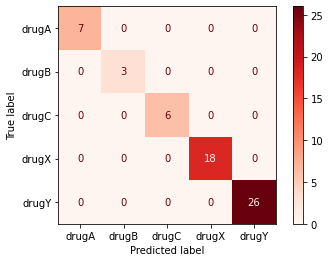

In [23]:
# Se utliza la matriz de confusión para evaluar la precisión de una clasificación.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Necesita dos variables que contengan los valores a comparar
cm = confusion_matrix(y_test, y_hat)

# Código para realizar la representación gráfica con los resultados
# Se crea la varible cmd, que almacena visualization de la Confusion Matrix 
# Necesita la variable cm que contiene los resultados de la comparación entre los valores reales
# y predicción
# display_labels, se especifica las etiquetas de las categorias que se evalúan.
cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)

# Con cmd.plot se especifica el mapa de colores reconocido por matplotlib.
cmd.plot(cmap=plt.cm.Reds)

# Para mostrar la figura
plt.show()

# Utilizar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline6.png" width="1000" align="middle">

In [24]:
df_prueba = pd.DataFrame({"Age":[28],"Na_to_K": [29.400], "Sex": ["F"], "BP": ["HIGH"], "Cholesterol": ["HIGH"]})
df_prueba

,Age,Na_to_K,Sex,BP,Cholesterol
0,28,29.4,F,HIGH,HIGH


In [25]:
# Implementar el label encoder
le_transform_sex = le_sex.transform(df_prueba['Sex'])
le_transform_bp = le_bp.transform(df_prueba['BP'])
le_transform_cholesterol  = le_cholesterol.transform(df_prueba['Cholesterol'])

# Implementar el OneHotEncoder
ohe_transform_sex = ohe_sex.transform(le_transform_sex.reshape(-1, 1))
ohe_transform_bp = ohe_bp.transform(le_transform_bp.reshape(-1, 1))
ohe_transform_cholesterol  = ohe_cholesterol.transform(le_transform_cholesterol.reshape(-1, 1))

# Armar un DataFrame para cada OneHotEncoder
df_ohe_sex = pd.DataFrame(ohe_transform_sex, columns=le_sex.classes_, dtype=int).add_prefix('Sex'+'_')
df_ohe_bp = pd.DataFrame(ohe_transform_bp, columns=le_bp .classes_, dtype=int).add_prefix('BP'+'_')
df_ohe_cholesterol = pd.DataFrame(ohe_transform_cholesterol, columns=le_cholesterol.classes_, dtype=int).add_prefix('Cholesterol'+'_')

# Unir
df_unido = df_ohe_sex.join(df_ohe_bp)
df_unido = df_unido.join(df_ohe_cholesterol)
df_unido = df_prueba.join(df_unido)

# # Eliminar vieja columna del dataset
df_unido = df_unido.drop(['Sex'], axis=1)
df_unido = df_unido.drop(['BP'], axis=1)
df_unido = df_unido.drop(['Cholesterol'], axis=1)
df_unido 



,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,28,29.4,1,0,1,0,0,1,0


In [26]:
X_prueba = df_unido.values
y_hat_prueba = clf.predict(X_prueba)
y_hat_prueba

array(['drugY'], dtype=object)

In [27]:
# Se importa tree de sklearn
from sklearn import tree

# Tomo el primer árbol de decisión del bosque para dibujar
estimator = clf.estimators_[0]  

# Obtengo los nombres de las columnas utilizadas y las clases posibles
feature_names = df_codificado.drop('Drug', axis=1).columns
class_names = df_codificado['Drug'].unique().tolist()
class_names

['drugY', 'drugC', 'drugX', 'drugA', 'drugB']

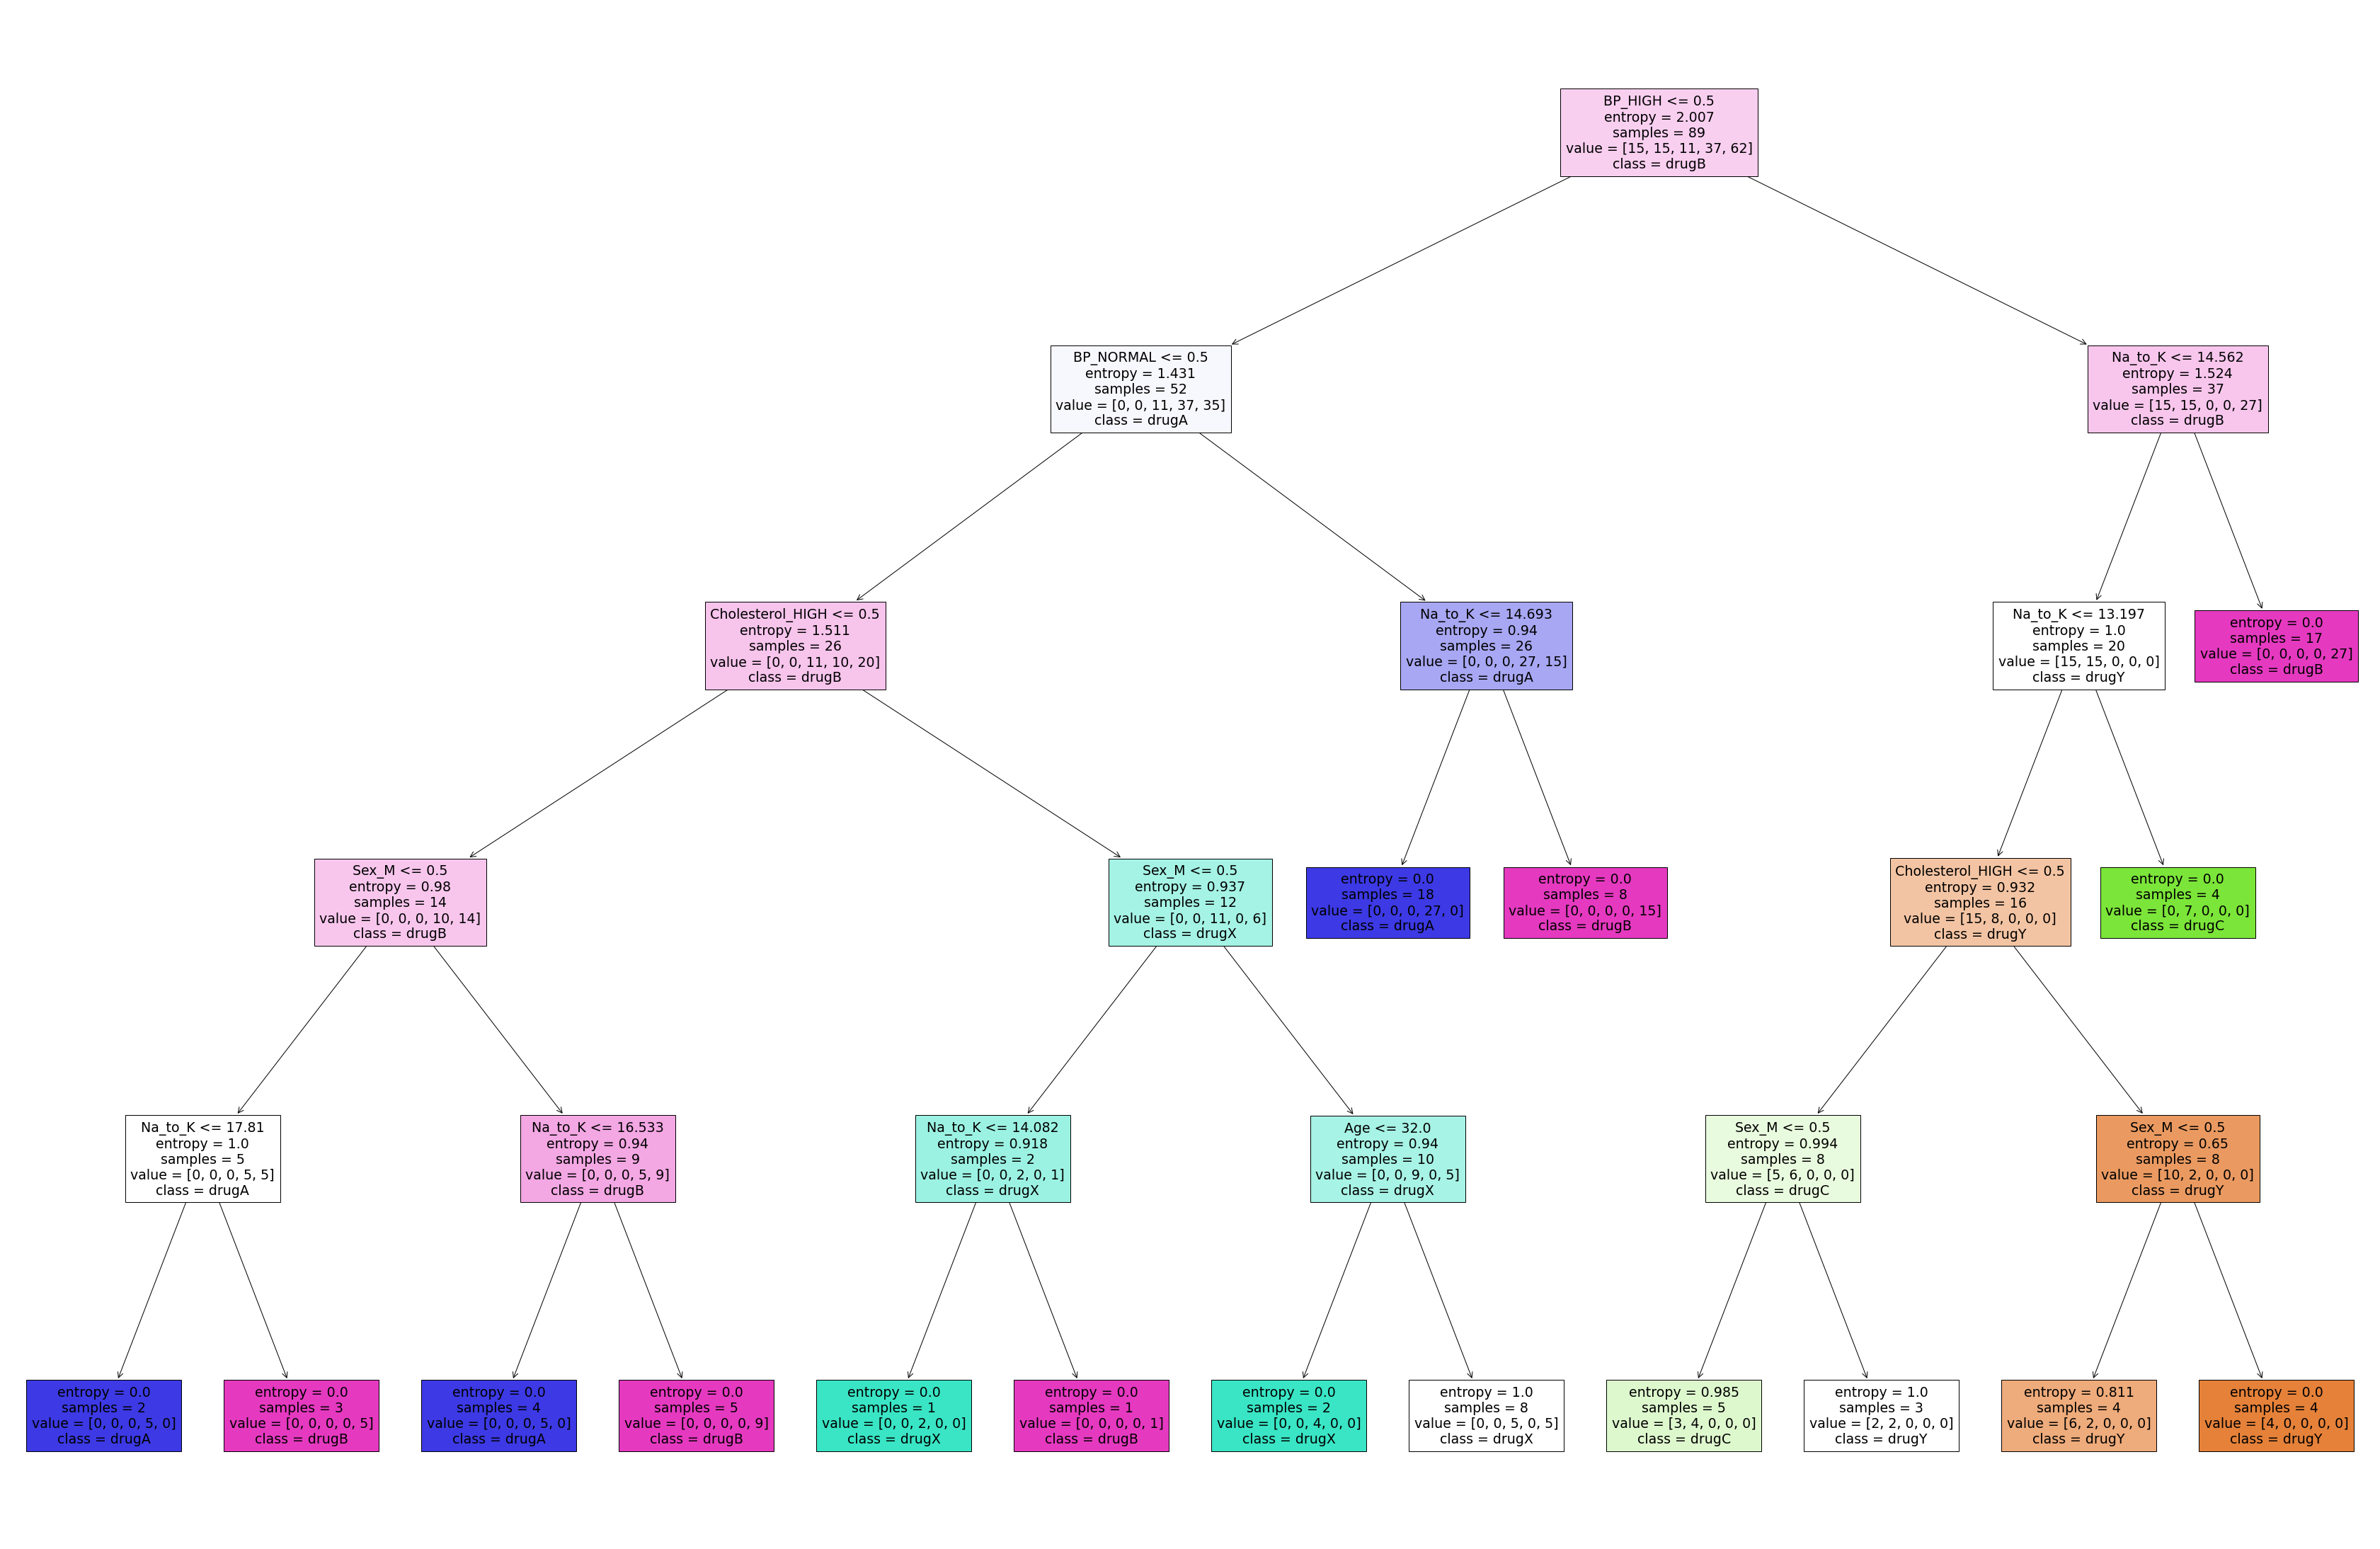

In [28]:
# Se importa tree de sklearn
from sklearn import tree

# Tomo el primer árbol de decisión del bosque para dibujar
estimator = clf.estimators_[0]  ## estimator--> DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',random_state=209652396)

# Obtengo los nombres de las columnas utilizadas y las clases posibles
# del DataFrame "df_codificado" elimina la columna "Drug" y obtiene los nombres de las columnas
#features_names devuelve los nombre de las columnas--> Index(['Age', 'Na_to_K', 'Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 
#'BP_NORMAL','Cholesterol_HIGH', 'Cholesterol_NORMAL'], dtype='object')
feature_names = df_codificado.drop('Drug', axis=1).columns

# Accede al DataFrame "df_codificado" a su columna "Drug"
# Con el método .unique() busca las categorías únicas 
# y devuelve la información en una lista con el método .tolist()
# class_names las categorías que representan la columna---> ['drugY', 'drugC', 'drugX', 'drugA', 'drugB']
class_names = df_codificado['Drug'].unique().tolist()

# Se crea el espacio para dibujar con fig = plt.figure(figsize=(16, 9))
# Se crea el espacio para el gráfico ax = fig.add_subplot()
fig = plt.figure(figsize=(60,40))
ax = fig.add_subplot()

# tree, variable del árbol, accede al método plot_tree para representarlo graficamente
# Indicando los parámetros:
# estimator --> Cantidad de árboles, el primero indicado en estimator = clf.estimators_[0]
# feature_names = feature_names, los nombre de las columnas--> Index(['Age', 'Na_to_K', 'Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 
#'BP_NORMAL','Cholesterol_HIGH', 'Cholesterol_NORMAL'], dtype='object')
# class_names=class_names, class_names las categorías que representan la columna---> ['drugY', 'drugC', 'drugX', 'drugA', 'drugB']
# filles=True, Cuando se establece en True, pinta los nodos para indicar la clase mayoritaria para la clasificación.
# ax=ax, Ejes para trazar el gráfico.
# Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
tree.plot_tree(estimator,
               feature_names = feature_names, 
               class_names=class_names,
               filled = True,
               ax=ax);
# Muetra la figura
plt.show()
# Nombre de la imagen
filename = 'drugtree.png'
# fig.savefig, guarda la imagen con el nombre asignado.
fig.savefig(filename)

# Conclusión
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline7.png" width="1000" align="middle">

En este ejemplo no fue muy dificil conseguir un buen resultado ya que no era un dataset complejo. La misma estrategía de trabajo puede aplicarse para otros datasets